In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# Code example
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import h5py

In [2]:
# resampled_X = pd.DataFrame(data=None, columns=dataset.columns)
def bootstrap_resample(X, n=1000,flag=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if flag == True:
        return X
    resampled_X = pd.DataFrame(data=None, columns=dataset.columns)
    for i in range(4):
        if i in [1,2]:
            index = X[X['PID'] == i].index.values
            resample_index = np.random.choice(index,n)
            resampled_X = resampled_X.append(X.loc[resample_index],ignore_index=True)
        else:
            index = X[X['PID'] == i].index.values
            resampled_X = resampled_X.append(X.loc[index],ignore_index=True)
    return resampled_X


In [3]:
def load_data(n=1000000):
    f = h5py.File('s000_f00012_ts1524050665_Phys.h5', 'r')
    data = np.array(f['PhysPulse'][:n])
    x = np.column_stack((data['E'],data['dt'],data['PE'],data['PSD'],data['PID']))
    column = [  'E','dt', 'PE1', 'PE2',  'PSD', 'PID' ]
    dataset = pd.DataFrame(x, columns=column)
    print(dataset.shape)
    return dataset

dataset = load_data(1000000)


(1000000, 6)


In [4]:
resample=True
def clean_data(dataset,resample=True):
    print(dataset['PID'].unique())
    dataset.drop( dataset[ dataset.PID == 6 ].index, inplace=True )
    dataset.drop( dataset[ dataset.PID == 32 ].index, inplace=True )
    dataset.drop( dataset[ dataset.PID == 128 ].index, inplace=True )
    dataset.drop( dataset[ dataset.PID == 258 ].index, inplace=True )
    output = dataset['PID'].unique()
    dataset['PID'].replace({ 1:0, 4:1, 256:2, 512:3 } , inplace=True)
    
    if resample == True:
        print("using bootstrap: \n")
        dataset_resample = bootstrap_resample(dataset,n=1000000)
        print(dataset['PID'].value_counts())
        print(dataset_resample['PID'].value_counts())
        
        train_dataset = dataset_resample.sample(frac=0.8,random_state=0)
        train_labels = train_dataset.pop('PID')
        
        dummy = dataset.sample(frac=0.8,random_state=0)        
        test_dataset = dataset.drop(dummy.index)
        test_labels = test_dataset.pop('PID')
    else:
        print(" NOT using bootstrap: \n")        
        train_dataset = dataset.sample(frac=0.8,random_state=0)
        train_labels = train_dataset.pop('PID')
        test_dataset = dataset.drop(train_dataset.index)
        test_labels = test_dataset.pop('PID')
        print(dataset['PID'].value_counts())
    
    return output, train_dataset, train_labels, test_dataset, test_labels

output, train_dataset, train_labels, test_dataset, test_labels = clean_data(dataset,resample=resample)

[  1.   4. 256. 512. 128.  32.   6. 258.]
using bootstrap: 

0.0    769448
3.0    190875
1.0     28453
2.0      4519
Name: PID, dtype: int64
1.0    1000000
2.0    1000000
0.0     769448
3.0     190875
Name: PID, dtype: int64


In [5]:
# 0:'electron/gamma/muon ionization'
# 1:"nucleus recoil"
# 2:'scintillator-in-housing "ingress" high-PSD event' 
# 3:'big signal (muon likely) hit'

In [6]:

def plot_learning_curve(history):
    """ Function that accepts the result from a training run and generates loss curves. """
    plt.plot(history["loss"], label="training loss")
    plt.plot(history["val_loss"], label="validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.yscale('log')
    plt.legend()
    plt.savefig('history.pdf')
    plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_dataset.keys()),)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(output))
])
# tf.keras.optimizers.Adam(lr=0.001),
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
result = model.fit(train_dataset, train_labels, epochs=20, batch_size=64, validation_split = 0.2 ) 

Epoch 1/20
29604/29604 [==============================] - 31s 1ms/step - loss: 0.7704 - val_loss: 0.1864
Epoch 2/20
29604/29604 [==============================] - 32s 1ms/step - loss: 0.1724 - val_loss: 0.1740
Epoch 3/20
29604/29604 [==============================] - 32s 1ms/step - loss: 0.1579 - val_loss: 0.1354
Epoch 4/20
29604/29604 [==============================] - 33s 1ms/step - loss: 0.1460 - val_loss: 0.1335
Epoch 5/20
29604/29604 [==============================] - 33s 1ms/step - loss: 0.1255 - val_loss: 0.1301
Epoch 6/20
29604/29604 [==============================] - 35s 1ms/step - loss: 0.1233 - val_loss: 0.1063
Epoch 7/20
29604/29604 [==============================] - 37s 1ms/step - loss: 0.1191 - val_loss: 0.1018
Epoch 8/20
29604/29604 [==============================] - 37s 1ms/step - loss: 0.1132 - val_loss: 0.0929
Epoch 9/20
29604/29604 [==============================] - 52s 2ms/step - loss: 0.1076 - val_loss: 0.0879
Epoch 10/20
29604/29604 [==============================

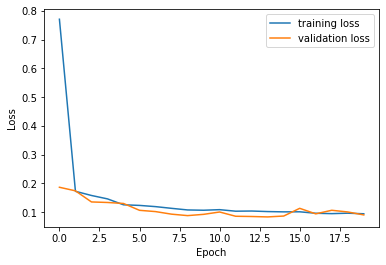

In [8]:
plot_learning_curve(result.history)

In [9]:
def predict():
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    predictions = probability_model.predict(test_dataset)
    Label = [ np.argmax(x) for x in predictions ]
    Label = pd.Series(Label,name='Predict')
    
    testD = test_dataset.copy()
    testD.reset_index(drop=True, inplace=True)
    testD_labels = test_labels.copy()
    testD_labels.reset_index(drop=True, inplace=True)
    
    result = pd.concat([testD, Label ,testD_labels], axis=1)
    print(result['PID'].value_counts())
    return result
result = predict()

0.0    154029
3.0     37938
1.0      5815
2.0       877
Name: PID, dtype: int64


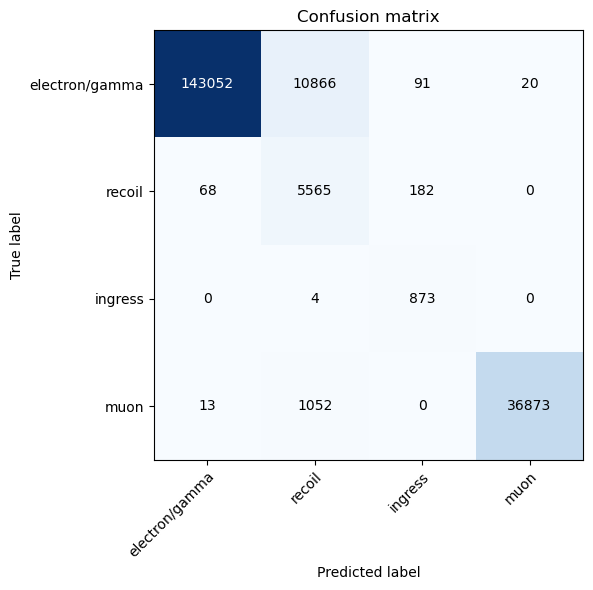

In [10]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()
    

    
plot_confusion_matrix(result['PID'],result['Predict'],['electron/gamma','recoil','ingress','muon'])

In [11]:
# from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
#                              matthews_corrcoef, roc_curve, roc_auc_score)
# def plot_roc_auc(labels, pred):
#     """ Plots the Receiver-Operator Characteristic Curve with Area Under Curve.
#     """
#     fpr, tpr, thresholds = roc_curve(labels, pred)
#     roc_auc = roc_auc_score(labels, pred)

#     fig, ax = plt.subplots()
#     ax.plot(fpr, tpr, color='darkorange', lw=2,
#             label="ROC curve (area = {:0.2f})".format(roc_auc))
#     ax.plot([0, 1], [0, 1], color='navy', lw=2,
#             linestyle='--', label="Random classifier")
#     ax.set_xlim([0.0, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.set_title('Receiver operating characteristic')
#     ax.legend()
    
    
# plot_roc_auc(result['PID'],predictions)

In [12]:
# SMALL_SIZE = 20
# MEDIUM_SIZE = 25
# BIGGER_SIZE = 30
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# # # plt.rcParams['axes.spines.right'] = True
# # rc = {"axes.spines.bottom" : False,
# #       "axes.spines.top"    : False,
# #       "figur.titlesize"    : BIGGER_SIZE ,
# #       "axes.spines.right"  : False}
# # plt.style.use(("seaborn-colorblind", rc))
# # plt.style.use('py_style')

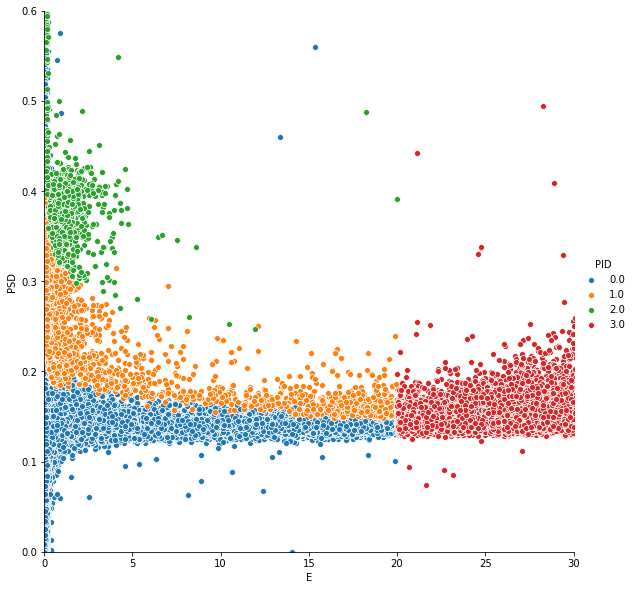

In [13]:
# sns.despine(top=False,right=False)
ax = sns.pairplot(x_vars=["E"], y_vars=["PSD"], data=result, hue="PID", height=8)
ax.set(xlim=(0,30))
ax.set(ylim=(0,0.6))
plt.savefig("test.png")

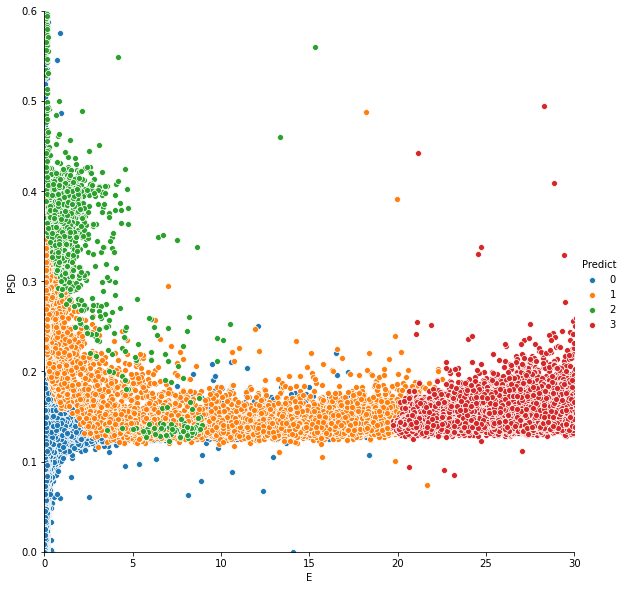

In [14]:
ax = sns.pairplot(x_vars=["E"], y_vars=["PSD"], data=result, hue="Predict", height=8)
ax.set(xlim=(0,30))
ax.set(ylim=(0,0.6))
# plt.savefig("prediction.pdf")
plt.savefig("prediction.png")